<center><b>Sentiment Analysis using RNN, LSTM and GRU</b></center>

<ul>
    <li>The dataset can be downloaded at <a href="https://nlp.stanford.edu/sentiment">https://nlp.stanford.edu/sentiment</a> under Dataset Download -> Main zip file with readme (6mb).</li>
    <li>The polarity data can be downloaded from <a href="http://www.cs.cornell.edu/people/pabo/movie-review-data">http://www.cs.cornell.edu/people/pabo/movie-review-data</a> under Sentiment polarity datasets.</li>
</ul>

In [2]:
import os
import urllib
import zipfile
import nltk
import re
import numpy as np
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

from numpy import array
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

<b>Loading the Glove embedding of 300 dimension size</b>

In [2]:
#Loading Glove model

def loadGloveModel(gloveFile):
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    f.close()
    return model

print("Loading Glove Model of 300 dimensions")
gloveModel = loadGloveModel("glove.6B.300d.txt")

Loading Glove Model of 300 dimensions
Done. 400000  words loaded!


<b>Loading the train/test/dev split from file as a dictionary object for easier lookup</b>

In [118]:
datasetSplitFile = 'stanfordSentimentTreebank\stanfordSentimentTreebank\datasetSplit.txt'
def produceSplit(data, datasetSplitFile):
    splitMap = {}
    f = open(datasetSplitFile, 'r')
    next(f)
    count = 0
    for line in f:
        line = line.strip()
        stmtid, dataType = line.split(',')
        splitMap[int(stmtid)] = int(dataType)
    f.close()
    return splitMap
    
splitMap = produceSplit(None, datasetSplitFile)
print("Length:", len(splitMap))

Length: 11855


<b>Mapping the reviews to their positive/negative labels</b>

In [127]:
dataFile = "stanfordSentimentTreebank\\stanfordSentimentTreebank\\original_rt_snippets.txt"
positiveLabels = "rt-polaritydata\\rt-polarity.pos"
negativeLabels = "rt-polaritydata\\rt-polarity.neg"
sentenceDataFile = "stanfordSentimentTreebank\\stanfordSentimentTreebank\\datasetSentences.txt"

In [126]:
#Method to perform text processing to convert positive/negative snippets to format matching the original rt review text
def getTransformedReview(line):
    line = line.lower()
    line = line.strip()
    line = line.replace(' . ', '')
    line = line.replace('. ', '')
    line = line.replace(' .', '')
    line = line.replace('.', '')
    line = line.replace("… ", '')
    line = line.replace("…", '')
    line = line.replace(' , ', ', ')
    line = line.replace(' :', ':')
    line = line.replace(' ;', ';')
    line = line.replace('( ', '')
    line = line.replace(' )', '')
    line = line.replace('[', '')
    line = line.replace(' ]', '')
    line = line.replace('] ', ' ')
    line = line.replace(']', '')
    line = line.replace(' \"', '')
    line = line.replace('\" ', '')
    line = line.replace('\"', '')
    line = line.replace('\'', '')
    line = line.replace(' ? s', 's')
    line = line.replace(' ?', '')
    line = line.replace('? ', '')
    line = line.replace('?', '')
    line = line.replace(' ! ', ' ')
    line = line.replace(' !', '')
    line = line.replace('! ', '')
    line = line.replace('!', '')
    line = line.replace("<b>", '')
    line = line.replace("</b>", '')
    line = line.replace("<em>", '')
    line = line.replace("</em>", '')
    line = line.replace('`', '')
    line = line.replace('—', '--')
    line = line.replace("  ", " ")
    return line.strip()

#Method to extract the positive and negative labelled reviews
def populateLabelFiles(posFile, negFile):
    positiveFile = open(posFile, 'r')
    posRev = []
    for line in positiveFile:
        line = getTransformedReview(line)
        posRev.append(line[:20])
    positiveFile.close()
    
    negativeFile = open(negFile, 'r')
    negRev = []
    for line in negativeFile:
        line = getTransformedReview(line)
        negRev.append(line[:20])
    negativeFile.close()
    return posRev, negRev

#Method to perform text processing to convert original rt reviews to format matching the positive/negative review snippets
def getTransformedLine(line):
    refLine = line.lower()
    refLine = refLine.replace('(', '')
    refLine = refLine.replace(')c', ' c')
    refLine = refLine.replace(')', '')
    refLine = refLine.replace("``", '')
    refLine = refLine.replace("''", '')
    refLine = refLine.replace("’", '')
    refLine = refLine.replace(' . ', '')
    refLine = refLine.replace('. ', '')
    refLine = refLine.replace(' .', '')
    refLine = refLine.replace('.', '')
    refLine = refLine.replace(' , ', ', ')
    refLine = refLine.replace("  ", " ")
    refLine = refLine.replace(" \'s ", 's ')
    refLine = refLine.replace(' \'d ', 'd ')
    refLine = refLine.replace('\'', '')
    refLine = refLine.replace('\/', '/')
    refLine = refLine.replace("?", "")
    refLine = refLine.replace("!", "")
    refLine = refLine.replace('`', '')
    refLine = refLine.strip()
    return refLine

#Method to read and populate the data and its corresponding labels for the RT reviews
def readData(dataFile, posFile, negFile):
    dataFilePointer = open(dataFile, 'r', encoding="utf8")
    count = 0
    dataset = []
    dataLabels = []
    posReview, negReview = populateLabelFiles(posFile, negFile)
    for line in dataFilePointer:
        line = line.strip()
        refLine = getTransformedLine(line)
        
        #Additional pre-processing is done here to facilitate matching between reviews and statement wise data
        dataset.append(refLine.replace("--", "–").replace("½", "1/2").replace('\"', '').replace("–-", "–").replace(" ", ""))
        
        if refLine[:20] in posReview:
            dataLabels.append(1)
        elif refLine[:20] in negReview:
            dataLabels.append(0)
        else:
            print("Error")
            print(refLine)
            break
    dataFilePointer.close()
    return dataset, dataLabels
    
reviewData, reviewDataLabels = readData(dataFile, positiveLabels, negativeLabels)

<b>Processing the reviews:</b>
<ul>
    <li>The reviews in RT file are transformed to match the sentences in positive and negative files for matching purposes.</li>
    <li>The reviews are further pre-processed for matching the dataset sentences in the next step. The transformations were observed by iterative processing of the RT reviews, positive/negative and the dataset files.</li>
    <li>Regular Expressions were tried but due to the difference in the order of sentences between the RT reviews and the positive/negative, they weren't effective. Thus, explicit transformations in the required order were utilized.</li>
</ul>

In [3]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemma_str = ""
    for w in w_tokenizer.tokenize(text):
        lemma_str += lemmatizer.lemmatize(w) + " "
    return lemma_str

stopWords = set(stopwords.words('english'))

def remove_stop_words(text):
    return_str = ""
    for w in w_tokenizer.tokenize(text):
        if w not in stopWords:
            return_str += w + " "
    return return_str

In [133]:
#Method to get transformed statements to match the review statements
def getTransformedStmt(line):
    refLine = line.lower()
    
    #START punctuation transformation
    refLine = refLine.replace('(', '').replace(')c', ' c').replace(')', '').replace("``", '').replace("’", '')
    refLine = refLine.replace(' . ', '').replace('. ', '').replace(' .', '').replace('.', '').replace(' , ', ', ')
    refLine = refLine.replace("  ", " ").replace(" \'s ", 's ').replace(' \'d ', 'd ').replace('\'', '').replace('\/', '/')
    refLine = refLine.replace('\\', '').replace("?", "").replace("!", "").replace('`', '')
    refLine = refLine.strip()
    #END punctuation transformation
    
    refLine = refLine.replace("can not", "cannot").replace(" nt", "nt").replace("` ", '').replace(" '", '').replace(' ;', ';')
    refLine = refLine.replace(' :', ':').replace('-lrb- ', '').replace('-rrb- ', '').replace('-rrb-', '').replace(" -8", "-8")
    refLine = refLine.replace(' ,', ',').replace('ã©', 'é').replace('ã­', 'í').replace('ã¼', 'ü').replace('ã³', 'ó')
    refLine = refLine.replace('ã¡', 'á').replace('ã¦', 'æ').replace('ã', 'à').replace('â', '').replace('à¢', 'â')
    refLine = refLine.replace('à±', 'ñ').replace('à¯', 'ï').replace('à´', 'ô').replace('à¨', 'è').replace('à¶', 'ö')
    refLine = refLine.replace('à£', 'ã').replace('à»', 'û').replace('à§', 'ç').replace(' ', '').replace("--", "–")
    refLine = refLine.replace("--", "–").replace(' ', '')
    return refLine

#Method to get the clean version of the review statements for training/validation/testing
def getCleanedReview(refLine):
    refLine = refLine.replace("``", '').replace("’", '').replace('`', '')
    
    refLine = refLine.replace('-lrb- ', '').replace('-rrb- ', '').replace('-rrb-', '')
    
    refLine = refLine.replace('ã©', 'é').replace('ã­', 'í').replace('ã¼', 'ü').replace('ã³', 'ó').replace('ã¡', 'á')
    refLine = refLine.replace('ã¦', 'æ').replace('ã', 'à').replace('à¢', 'â').replace('à±', 'ñ').replace('à¯', 'ï')
    refLine = refLine.replace('à´', 'ô').replace('à¨', 'è').replace('à¶', 'ö').replace('à£', 'ã').replace('à»', 'û')
    refLine = refLine.replace('à§', 'ç')
    
    #return lemmatize_text(refLine)
    #return remove_stop_words(refLine)
    return refLine

#Method to match the statement in the review and obtain the corresponding label
def retLabel(reviewData, reviewDataLabels, line, i):
    searchLine = getTransformedStmt(line)
    indx = 0
    for entry in reviewData:
        if entry.startswith(searchLine):
            label = reviewDataLabels[indx]
            temp = entry.replace(searchLine, "", 1).strip()
            if temp == '':
                reviewData.pop(indx)
                reviewDataLabels.pop(indx)
            else:
                reviewData[indx] = temp
            return label
        indx += 1
    print(reviewData[0])
    print("searchline")
    print(searchLine)
    return -1

#Method to read the sentence data and generate train/test/development data along with their labels
def readSentenceData(dataFile, reviewData, reviewDataLabels):
    trainingData = []
    devData = []
    testData = []
    trainingLabels = []
    devLabels = []
    testLabels = []
    
    dataFilePointer = open(dataFile, "r", encoding="utf8")
    next(dataFilePointer)
    dataLabels = []
    count = 0
    for line in dataFilePointer:
        stmtId, stmt = line.split("\t")
        x = retLabel(reviewData, reviewDataLabels, stmt, count)
        if x != -1:
            stmt = getCleanedReview(stmt.strip())
            dataType = splitMap[int(stmtId)]
            if dataType == 1:
                trainingData.append(stmt)
                trainingLabels.append(x)
            elif dataType == 2:
                testData.append(stmt)
                testLabels.append(x)
            else:
                devData.append(stmt)
                devLabels.append(x)
        elif x == -1:
            print("Unexpected error for statement id: ", stmtId)
            count += 1
            break
    print("Incorrect:", count)
    return trainingData, trainingLabels, devData, devLabels, testData, testLabels
    
trainX, trainY, devX, devY, testX, testY = readSentenceData(sentenceDataFile, reviewData.copy(), reviewDataLabels.copy())
print("Train / test / dev split:", len(trainX), "/", len(testX), "/", len(devX))
print("Total:", len(trainX) + len(devX) + len(testX))

Incorrect: 0
Train / test / dev split: 8544 / 2210 / 1101
Total: 11855


In [134]:
#Generating the complete data corpus to pre-process the text
dataCorpus = trainX.copy()
dataCorpus.extend(devX)
dataCorpus.extend(testX)

<b>Pre-processing the data:</b>
<ul>
    <li><b>Words to indices</b>: Convert strings into corresponding word indices.</li>
    <li><b>Padding</b>: Pad the embedded matrices to generate equal length sentence embeddings.</li>
    <li><b>Lemmatization</b>: The lemmatizer was used while pre-processing the data. However, it was later identified that the performance of the models weren't increased by lemmatization and thus it isn't utilized.</li>
    <li><b>Stop words removal</b>: On removing the stop words from the data corpus, it was observed that the performance declined from 75% validation error to 73% error. For the given corpus, the context of the stop words seem to be an important factor. Thus, stop words weren't removed from the corpus prior to training the models.</li>
</ul>

In [135]:
def getEmbeddedData(data, tokenizerObj):
    return tokenizerObj.texts_to_sequences(data)

word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(dataCorpus)
vocab_length = len(word_tokenizer.word_index) + 1
print("Vocabulary length:", vocab_length)

embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedded_sentences_train = getEmbeddedData(trainX, word_tokenizer)

embedded_sentences_dev = getEmbeddedData(devX, word_tokenizer)

embedded_sentences_test = getEmbeddedData(testX, word_tokenizer)

Vocabulary length: 17840


In [151]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(dataCorpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence2))
print("Max length:", length_long_sentence)

padded_sentences_train = pad_sequences(embedded_sentences_train, length_long_sentence, padding='post')

padded_sentences_dev = pad_sequences(embedded_sentences_dev, length_long_sentence, padding='post')

padded_sentences_test = pad_sequences(embedded_sentences_test, length_long_sentence, padding='post')

Max length: 56


<b>Designing, training and evaluating the simple RNN model:</b>
<br>
The final hidden state is used to train the model.

In [172]:
#Method to plot the accuracy and loss graphs for the model
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    if string == "acc":
        plt.ylabel("accuracy")
    else:
        plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#Method to generate simple RNN model
def generateModel(embeddingObj, vocab_length, sequence_length, no_of_neurons, penalty = 0, learning_rate = 1e-4, toTrain = False):
    embedding_layer = Embedding(vocab_length, 
                             embeddingObj.shape[1], 
                             weights=[embeddingObj], 
                             input_length=sequence_length, 
                             trainable=toTrain, 
                             mask_zero=True) #This parameter excludes hidden states corresponding to padding
    
    model = tf.keras.Sequential([
        embedding_layer,
        tf.keras.layers.SimpleRNN(no_of_neurons, kernel_regularizer=keras.regularizers.l2(penalty)), #L2 regularization to prevent overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    return model
    
#Method to train the model
def trainModel(model, trainX, trainY, devX, devY, no_of_epochs = 10, batch_siz = 100):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
    history = model.fit(x = trainX, y = trainY,
                        epochs = no_of_epochs,
                        callbacks=[callback], #Early stopping to obtain best performing model on the validation data
                        validation_data = (devX, devY),
                        batch_size = batch_siz,
                        verbose = 0)
    plot_graphs(history, 'acc')
    plot_graphs(history, 'loss')
    return history, model

#Method to display the metrics
def displayMetrics(accuracy, precision, recall):
    f1 = (2 * precision * recall) / (precision + recall)
    print('Accuracy: %f' % (accuracy*100))
    print("Precision: ", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("\n")

#Method to evaluate the model using validation data
def evaluateModel(model, trainX, trainY, devX, devY):
    loss, accuracy, precision, recall = model.evaluate(trainX, trainY, verbose=0)
    print("Evaluation on training data")
    displayMetrics(accuracy, precision, recall)
    loss, accuracy, precision, recall = model.evaluate(devX, devY, verbose=0)
    print("Evaluation on validation data")
    displayMetrics(accuracy, precision, recall)
    
#Method to test the model on test data
def testModel(model, testX, testY):
    loss, accuracy, precision, recall = model.evaluate(testX, testY, verbose=0)
    print("Evaluation on test data")
    displayMetrics(accuracy, precision, recall)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 56, 300)           5352000   
_________________________________________________________________
simple_rnn_53 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 5,375,425
Trainable params: 23,425
Non-trainable params: 5,352,000
_________________________________________________________________
None


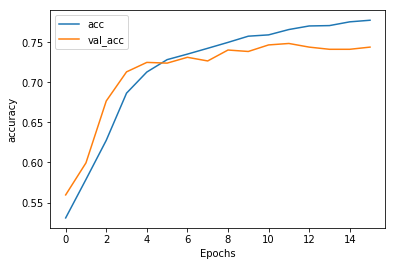

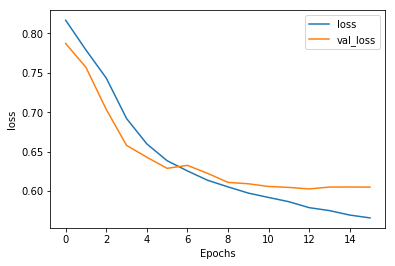

Evaluation on training data
Accuracy: 77.270597
Precision:  0.78628033
Recall: 0.74635637
F1-score: 0.765798387048269


Evaluation on validation data
Accuracy: 74.386919
Precision:  0.74264705
Recall: 0.73992676
F1-score: 0.7412844377579035




In [173]:
model = generateModel(embedding_matrix, vocab_length, length_long_sentence, 64, 0.001, 1e-4)
hist, model = trainModel(model, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model, padded_sentences_train, trainY, padded_sentences_dev, devY)

<b>Hyper-parameter tuning:</b>
<br>
The following parameters were tuned on the model and the best performing values were utilized.
<ol>
    <li><u>Learning rate:</u> The model overfit the training data for learning rate ~ 1. The convergence was slower for learning rate >= 1e-5. Thus, the learning rate of 1e-4 was utilized.</li>
    <li><u>Regularization:</u> It was observed initially that the model overfit the training data with accuracy in the range of higher 90 percentage but performed poorly on the validation data. Thus, L2 regularization is utilized.</li>
    <li><u>Early stopping:</u> Another technique used to avoid overfitting was to use early stopping to discontinue with training when the validation accuracy didn't improve for more than 3 epochs. It was generally observed that the validation accuracy stabilized after initial few epochs while training accuracy kept increasing. Thus, early stopping was used.</li>
    <li><u>Batch size:</u> Using smaller batches increased the performance of the model. Thus, a batch size of 100 was utilized in the model.</li>
</ol>

<b>Experimenting with the network structure:</b>

<b>1. Varying the number of hidden units</b>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 56, 300)           5352000   
_________________________________________________________________
simple_rnn_41 (SimpleRNN)    (None, 32)                10656     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 5,362,689
Trainable params: 10,689
Non-trainable params: 5,352,000
_________________________________________________________________
None


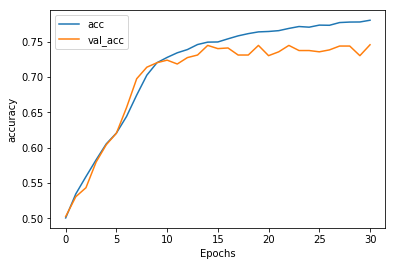

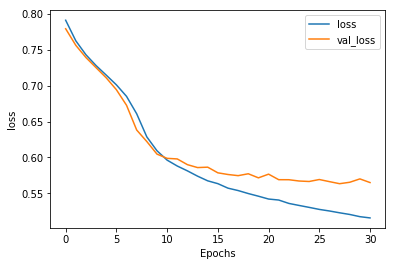

Evaluation on training data
Accuracy: 78.043073
Precision:  0.7947447
Recall: 0.75364363
F1-score: 0.7736486797417815


Evaluation on validation data
Accuracy: 74.386919
Precision:  0.7490566
Recall: 0.7271062
F1-score: 0.7379181959818479




In [146]:
#Halving the number of hidden units = 32
model2 = generateModel(embedding_matrix, vocab_length, length_long_sentence, 32, 0.001, 1e-4)
hist2, model2 = trainModel(model2, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model2, padded_sentences_train, trainY, padded_sentences_dev, devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 56, 300)           5352000   
_________________________________________________________________
simple_rnn_43 (SimpleRNN)    (None, 128)               54912     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 129       
Total params: 5,407,041
Trainable params: 55,041
Non-trainable params: 5,352,000
_________________________________________________________________
None


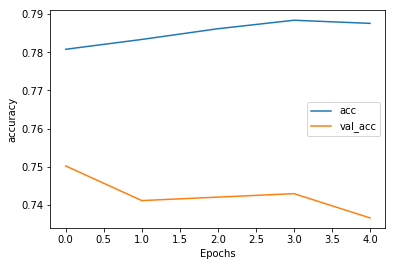

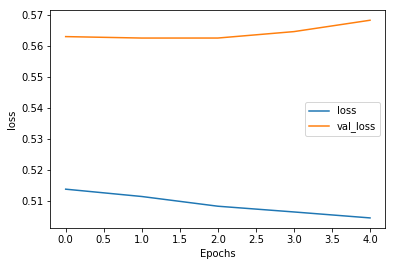

Evaluation on training data
Accuracy: 78.581458
Precision:  0.79925925
Recall: 0.7609309
F1-score: 0.779624244871654


Evaluation on validation data
Accuracy: 74.114442
Precision:  0.7448405
Recall: 0.7271062
F1-score: 0.7358665251389247




In [148]:
#Doubling the number of hidden units = 128
model3 = generateModel(embedding_matrix, vocab_length, length_long_sentence, 128, 0.001, 1e-4)
hist3, model3 = trainModel(model2, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model3, padded_sentences_train, trainY, padded_sentences_dev, devY)

<b>Observations:</b>
<ul>
    <li>Modifying the number of neurons doesn't have a major impact on the validation data. This could indicate the network isn't complex enough to solve the sentiment analysis problem.</li>
    <li>However, the convergence is faster for the network with the double number of hidden neurons.</li>
    <li>The F1 score metrix hovers around 0.73 which is in line with the original model's metric. This further indicates that the model is performing similar to the initial version.</li>
</ul>

<b>2. Sequence length</b>
<br>
Since the original model used the maximum length of all sentences in the corpus as the sequence length for the input, the new values will be half of max value and a value in between.

Current sequence length: 28
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 28, 300)           5352000   
_________________________________________________________________
simple_rnn_45 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 5,375,425
Trainable params: 23,425
Non-trainable params: 5,352,000
_________________________________________________________________
None


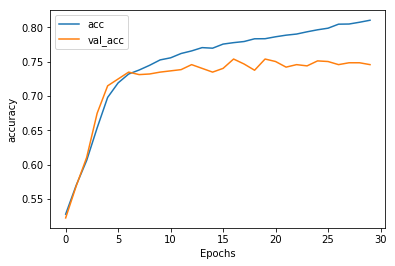

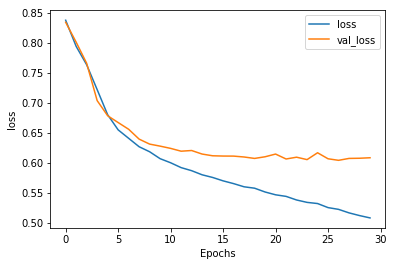

Evaluation on training data
Accuracy: 80.852062
Precision:  0.8287293
Recall: 0.7757405
F1-score: 0.8013598920076661


Evaluation on validation data
Accuracy: 74.568576
Precision:  0.7481343
Recall: 0.7344322
F1-score: 0.7412199195658816




In [155]:
#Halved sequence length = 28

halved_length = length_long_sentence//2
print("Current sequence length:", halved_length)

padded_sentences_train_halved = pad_sequences(embedded_sentences_train, halved_length, padding='post')

padded_sentences_dev_halved = pad_sequences(embedded_sentences_dev, halved_length, padding='post')

padded_sentences_test_halved = pad_sequences(embedded_sentences_test, halved_length, padding='post')

model4 = generateModel(embedding_matrix, vocab_length, halved_length, 64, 0.001, 1e-4)
hist, model4 = trainModel(model4, padded_sentences_train_halved, trainY, padded_sentences_dev_halved, devY, 100, 100)
evaluateModel(model4, padded_sentences_train_halved, trainY, padded_sentences_dev_halved, devY)

Current sequence length: 42
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     (None, 42, 300)           5352000   
_________________________________________________________________
simple_rnn_56 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 5,375,425
Trainable params: 23,425
Non-trainable params: 5,352,000
_________________________________________________________________
None


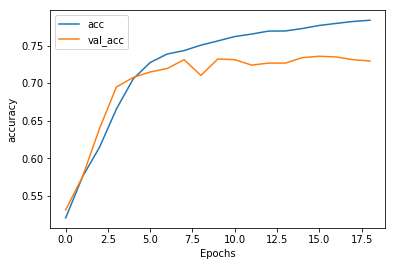

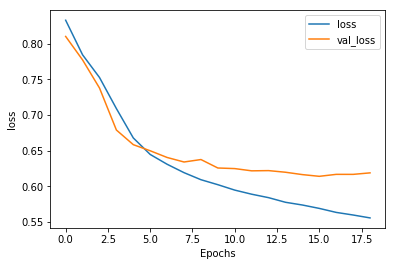

Evaluation on training data
Accuracy: 77.996254
Precision:  0.8187433
Recall: 0.7167372
F1-score: 0.7643519813014162


Evaluation on validation data
Accuracy: 73.569483
Precision:  0.75757575
Recall: 0.6868132
F1-score: 0.7204611154381929




In [182]:
#Sequence length between 28 and 56 = 42

inbetween_length = halved_length + length_long_sentence//4
print("Current sequence length:", inbetween_length)

padded_sentences_train_inbetween = pad_sequences(embedded_sentences_train, inbetween_length, padding='post')

padded_sentences_dev_inbetween = pad_sequences(embedded_sentences_dev, inbetween_length, padding='post')

padded_sentences_test_inbetween = pad_sequences(embedded_sentences_test, inbetween_length, padding='post')

model5 = generateModel(embedding_matrix, vocab_length, inbetween_length, 64, 0.001, 1e-4)
hist, model5 = trainModel(model5, padded_sentences_train_inbetween, trainY, padded_sentences_dev_inbetween, devY, 100, 100)
evaluateModel(model5, padded_sentences_train_inbetween, trainY, padded_sentences_dev_inbetween, devY)

Current sequence length: 14
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, 14, 300)           5352000   
_________________________________________________________________
simple_rnn_57 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 65        
Total params: 5,375,425
Trainable params: 23,425
Non-trainable params: 5,352,000
_________________________________________________________________
None


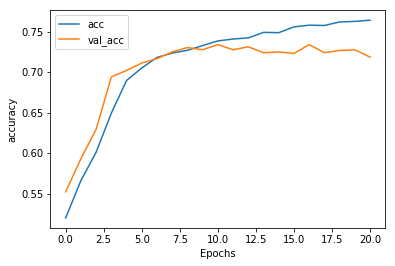

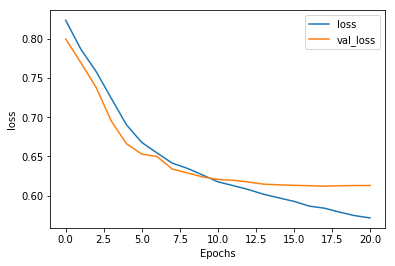

Evaluation on training data
Accuracy: 76.381087
Precision:  0.7760494
Recall: 0.738834
F1-score: 0.7569845744120112


Evaluation on validation data
Accuracy: 72.388738
Precision:  0.72
Recall: 0.72527474
F1-score: 0.7226277299618732




In [183]:
#Sequence length = 14

inbetween_length = 14
print("Current sequence length:", inbetween_length)

padded_sentences_train_inbetween = pad_sequences(embedded_sentences_train, inbetween_length, padding='post')

padded_sentences_dev_inbetween = pad_sequences(embedded_sentences_dev, inbetween_length, padding='post')

padded_sentences_test_inbetween = pad_sequences(embedded_sentences_test, inbetween_length, padding='post')

model5 = generateModel(embedding_matrix, vocab_length, inbetween_length, 64, 0.001, 1e-4)
hist, model5 = trainModel(model5, padded_sentences_train_inbetween, trainY, padded_sentences_dev_inbetween, devY, 100, 100)
evaluateModel(model5, padded_sentences_train_inbetween, trainY, padded_sentences_dev_inbetween, devY)

<b>Observations:</b>
<ul>
    <li>On halving the sequence length, the training accuracy goes up marginally. With less features to train, the model still doesn't perform better on the validation data.</li>
    <li>Since the data statements are smaller in length compared to the longest sentence, the sequence length is further reduced to 14. A drop in accuracy is encountered which indicates that important features might be lost by truncating.</li>
    <li>However, since the models with higher sequence lengths have employed masking to avoid padded hidden states, the performance of the models are approxiately the same.</li>
</ul>

<b>Glove embeddings with different dimensions:</b>

1. 50 dimensional embeddings

Loading Glove Model of 50 dimensions
Done. 400000  words loaded!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 56, 50)            892000    
_________________________________________________________________
simple_rnn_48 (SimpleRNN)    (None, 64)                7360      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 899,425
Trainable params: 7,425
Non-trainable params: 892,000
_________________________________________________________________
None


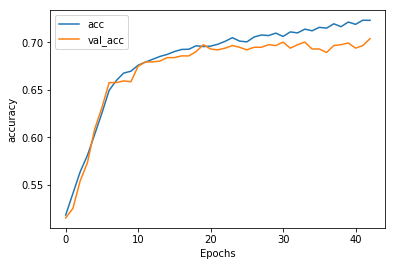

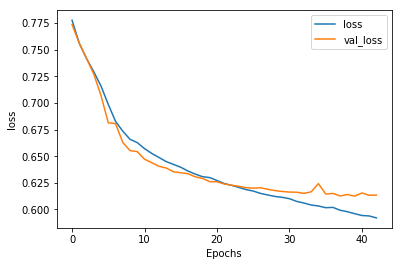

Evaluation on training data
Accuracy: 72.015452
Precision:  0.75839114
Recall: 0.6426892
F1-score: 0.6957628241779996


Evaluation on validation data
Accuracy: 69.936419
Precision:  0.7128713
Recall: 0.6593407
F1-score: 0.6850618985680346




In [163]:
print("Loading Glove Model of 50 dimensions")
gloveModel_50d = loadGloveModel("glove.6B.50d.txt")

embedding_matrix_50d = np.zeros((vocab_length, 50))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = gloveModel_50d.get(word)
    if embedding_vector is not None:
        embedding_matrix_50d[index] = embedding_vector

#Pre-trained embedding
model_50d = generateModel(embedding_matrix_50d, vocab_length, length_long_sentence, 64, 0.001, 1e-4)
hist_50d, model_50d = trainModel(model_50d, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_50d, padded_sentences_train, trainY, padded_sentences_dev, devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 56, 50)            892000    
_________________________________________________________________
simple_rnn_49 (SimpleRNN)    (None, 64)                7360      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 65        
Total params: 899,425
Trainable params: 899,425
Non-trainable params: 0
_________________________________________________________________
None


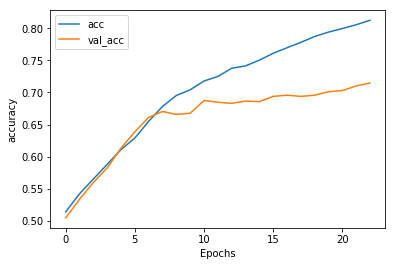

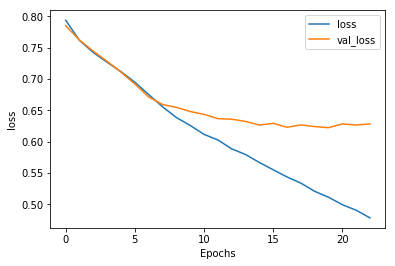

Evaluation on training data
Accuracy: 80.032772
Precision:  0.82335025
Recall: 0.7625764
F1-score: 0.7917988771748057


Evaluation on validation data
Accuracy: 70.118076
Precision:  0.70433146
Recall: 0.6849817
F1-score: 0.6945218033814317




In [165]:
#Fine trained embedding
model_50d = generateModel(embedding_matrix_50d, vocab_length, length_long_sentence, 64, 0.001, 1e-4, True)
hist_50d, model_50d = trainModel(model_50d, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_50d, padded_sentences_train, trainY, padded_sentences_dev, devY)

2. 100 dimensional embeddings

Loading Glove Model of 100 dimensions
Done. 400000  words loaded!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 56, 100)           1784000   
_________________________________________________________________
simple_rnn_50 (SimpleRNN)    (None, 64)                10560     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 1,794,625
Trainable params: 10,625
Non-trainable params: 1,784,000
_________________________________________________________________
None


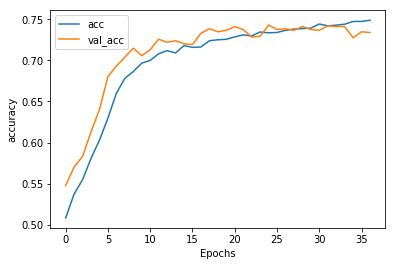

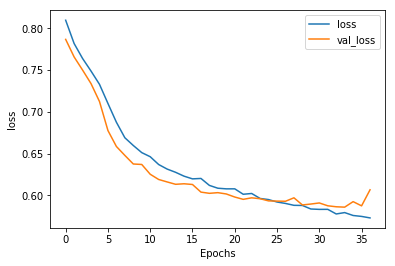

Evaluation on training data
Accuracy: 74.707395
Precision:  0.7703436
Recall: 0.7009873
F1-score: 0.7340307642594748


Evaluation on validation data
Accuracy: 74.114442
Precision:  0.75438595
Recall: 0.7087912
F1-score: 0.7308781427268283




In [166]:
print("Loading Glove Model of 100 dimensions")
gloveModel_100d = loadGloveModel("glove.6B.100d.txt")

embedding_matrix_100d = np.zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = gloveModel_100d.get(word)
    if embedding_vector is not None:
        embedding_matrix_100d[index] = embedding_vector
    
#Pre-trained embedding
model_100d = generateModel(embedding_matrix_100d, vocab_length, length_long_sentence, 64, 0.001, 1e-4)
hist_100d, model_100d = trainModel(model_100d, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_100d, padded_sentences_train, trainY, padded_sentences_dev, devY)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, 56, 100)           1784000   
_________________________________________________________________
simple_rnn_51 (SimpleRNN)    (None, 64)                10560     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total params: 1,794,625
Trainable params: 1,794,625
Non-trainable params: 0
_________________________________________________________________
None


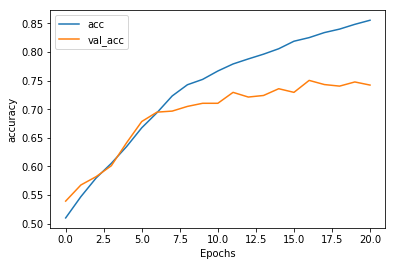

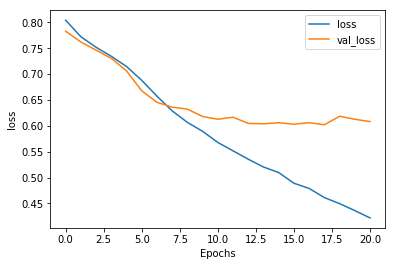

Evaluation on training data
Accuracy: 84.105808
Precision:  0.869954
Recall: 0.80042315
F1-score: 0.833741427869484


Evaluation on validation data
Accuracy: 74.296093
Precision:  0.7523992
Recall: 0.71794873
F1-score: 0.7347704104070846




In [167]:
#Fine trained embedding
model_100d = generateModel(embedding_matrix_100d, vocab_length, length_long_sentence, 64, 0.001, 1e-4, True)
hist_100d, model_100d = trainModel(model_100d, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_100d, padded_sentences_train, trainY, padded_sentences_dev, devY)

3. 300 dimensional embedding (fine tuning)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 56, 300)           5352000   
_________________________________________________________________
simple_rnn_52 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 65        
Total params: 5,375,425
Trainable params: 5,375,425
Non-trainable params: 0
_________________________________________________________________
None


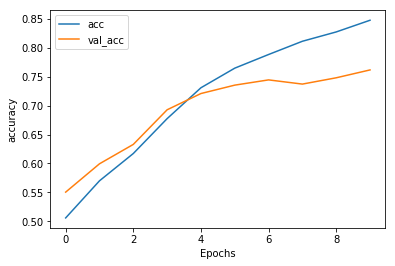

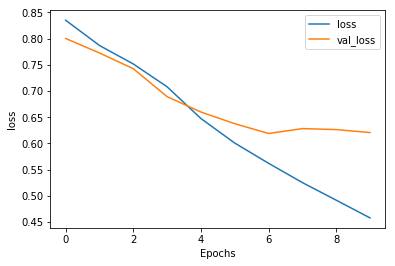

Evaluation on training data
Accuracy: 80.781835
Precision:  0.8426023
Recall: 0.75505406
F1-score: 0.7964294531682662


Evaluation on validation data
Accuracy: 74.477750
Precision:  0.7698574
Recall: 0.6923077
F1-score: 0.7290260346204088




In [168]:
model_300d = generateModel(embedding_matrix, vocab_length, length_long_sentence, 64, 0.001, 1e-4, True)
hist_300d, model_300d = trainModel(model_300d, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_300d, padded_sentences_train, trainY, padded_sentences_dev, devY)

<b>Observations:</b>
<ul>
    <li>The accuracy declines when using 50 dimensional embeddings. This is as expected since the trainable parameters increases drastically when compared to the initial Glove model.</li>
    <li>On fine tuning the 50 dimensional embeddings, the performance increases slightly.</li>
    <li>The same behavior can be observed in 100 dimensional embeddings as well, with performance better than 50 dimensional embeddings but lesser than 300 dimensional embeddings. On fine-tuning, the model begins to overfit quickly.</li>
    <li>For fine tuned 300 dimensional embeddings, the convergence is faster but the performance remains the same.</li>
    <li>In all 3 cases, it is observed that fine-tuning reduces the cost on training data vastly when compared to pre-trained vectors. This indicates that the embeddings are more useful when trained using the particular corpus used for the task.</li>
</ul>

<b>Designing, training and evaluating the vanilla LSTM model:</b>

In [171]:
def generateModel_LSTM(embeddingObj, vocab_length, sequence_length, no_of_neurons, penalty = 0, learning_rate = 1e-4, toTrain = False):
    embedding_layer = Embedding(vocab_length, 
                             embeddingObj.shape[1], 
                             weights=[embeddingObj], 
                             input_length=sequence_length, 
                             trainable=toTrain, 
                             mask_zero=True) #This parameter excludes hidden states corresponding to padding
    
    model = tf.keras.Sequential([
        embedding_layer,
        tf.keras.layers.LSTM(no_of_neurons, kernel_regularizer=keras.regularizers.l2(penalty)), #L2 regularization to prevent overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 56, 300)           5352000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 5,445,505
Trainable params: 93,505
Non-trainable params: 5,352,000
_________________________________________________________________
None


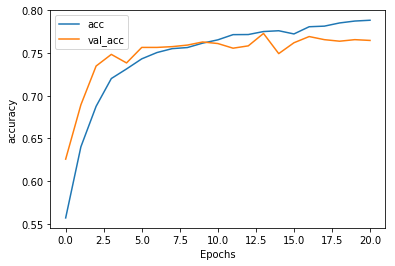

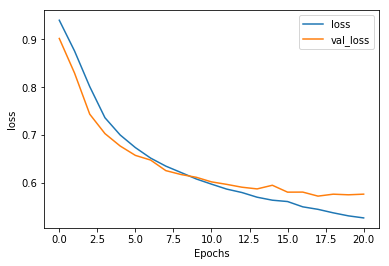

Evaluation on training data
Accuracy: 78.593165
Precision:  0.8050314
Recall: 0.7522332
F1-score: 0.777737295433735


Evaluation on validation data
Accuracy: 76.566756
Precision:  0.76865673
Recall: 0.75457877
F1-score: 0.7615526648580083




In [175]:
model_LSTM = generateModel_LSTM(embedding_matrix, vocab_length, length_long_sentence, 64, 0.001, 1e-4)
hist_LSTM, model_LSTM = trainModel(model_LSTM, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_LSTM, padded_sentences_train, trainY, padded_sentences_dev, devY)

<b>Designing, training and evaluating the vanilla GRU model:</b>

In [176]:
def generateModel_GRU(embeddingObj, vocab_length, sequence_length, no_of_neurons, penalty = 0, learning_rate = 1e-4, toTrain = False):
    embedding_layer = Embedding(vocab_length, 
                             embeddingObj.shape[1], 
                             weights=[embeddingObj], 
                             input_length=sequence_length, 
                             trainable=toTrain, 
                             mask_zero=True) #This parameter excludes hidden states corresponding to padding
    
    model = tf.keras.Sequential([
        embedding_layer,
        tf.keras.layers.GRU(no_of_neurons, kernel_regularizer=keras.regularizers.l2(penalty)), #L2 regularization to prevent overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 56, 300)           5352000   
_________________________________________________________________
gru (GRU)                    (None, 64)                70080     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 5,422,145
Trainable params: 70,145
Non-trainable params: 5,352,000
_________________________________________________________________
None


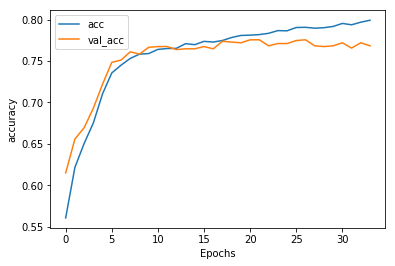

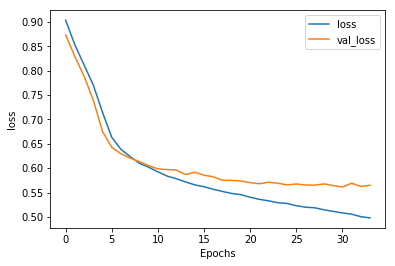

Evaluation on training data
Accuracy: 79.740167
Precision:  0.82538044
Recall: 0.7522332
F1-score: 0.7871110924221508


Evaluation on validation data
Accuracy: 77.202541
Precision:  0.7809524
Recall: 0.75091577
F1-score: 0.7656395733700229




In [177]:
model_GRU = generateModel_GRU(embedding_matrix, vocab_length, length_long_sentence, 64, 0.001, 1e-4)
hist_GRU, model_GRU = trainModel(model_GRU, padded_sentences_train, trainY, padded_sentences_dev, devY, 100, 100)
evaluateModel(model_GRU, padded_sentences_train, trainY, padded_sentences_dev, devY)

<b>Evaluating on the test data</b>

In [180]:
print("Vanilla RNN model")
testModel(model, padded_sentences_test, testY)

print("Vanilla LSTM model")
testModel(model_LSTM, padded_sentences_test, testY)

print("Vanilla GRU model")
testModel(model_GRU, padded_sentences_test, testY)

Vanilla RNN model
Evaluation on test data
Accuracy: 74.298644
Precision:  0.74647886
Recall: 0.7273559
F1-score: 0.7367933166367308


Vanilla LSTM model
Evaluation on test data
Accuracy: 75.656110
Precision:  0.76708376
Recall: 0.7291857
F1-score: 0.7476547841945154


Vanilla GRU model
Evaluation on test data
Accuracy: 75.791854
Precision:  0.7740668
Recall: 0.7209515
F1-score: 0.7465656358317607




<b>Observations:</b>
<ul>
    <li>The best parameters identified for vanilla RNN is used to build and evaluate models using LSTM and GRU.</li>
    <li>On evaluating these models using the test data, the GRU model performs slightly better than LSTM which in turn performs better than RNN.</li>
    <li>This is in line with general observations where LSTMs and GRUs have higher performance over RNNs.</li>
    <li>However, the F1 score presents a slightly different picture. The LSTM model has a better F1 score. Due to its memory units, the precision and recall are slightly higher than other models, thus resulting in a slightly higher F1 score.</li>
    <li>Another main difference is that the LSTM network converges faster than other models, but the training time per epoch is longer than GRUs and RNNs.</li>
    <li>Since LSTMs remember longer sequences than GRUs and the final hidden state is used in the networks, the LSTM model has slightly better performance since the network models long sentences in the corpus.</li>
    <li>Overall, it can be concluded that the performance of all the 3 networks are approximately in the same range which can be attributed to the simple nature of the networks.</li>
</ul>